Initializes notebook: inline plots, adds src/ to Python path, sets IMAGES_DIR to images1/, and prints the path.

In [ ]:
# Initial setup: paths and imports
%matplotlib inline
from pathlib import Path
import sys

ROOT = Path.cwd()
SRC_DIR = ROOT / 'src'
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))  # allow `import ...` from local src/

IMAGES_DIR = ROOT / 'images1'
print('Ready. Images path:', IMAGES_DIR)

Lists JPGs in IMAGES_DIR and displays the first one (RGB) with title and shape.

In [ ]:
# Preview a sample image (robust if setup cell wasn't run)
from pathlib import Path
from skimage import io
import matplotlib.pyplot as plt

IMAGES_DIR = globals().get('IMAGES_DIR', Path.cwd() / 'images1')

image_files = sorted(IMAGES_DIR.glob('*.jpg'))
assert image_files, f'No .jpg images found in {IMAGES_DIR}'

img_path = image_files[0]
img = io.imread(img_path)  # RGB

plt.imshow(img)
plt.title(img_path.name)
plt.axis('off')
print('Image shape:', img.shape)

Binarize the sample image: convert to grayscale, lightly blur, apply Otsu threshold, and show original vs binary.

In [ ]:
# Binarize image: grayscale -> blur -> Otsu threshold
from pathlib import Path
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import gaussian, threshold_otsu
import matplotlib.pyplot as plt

# reuse loaded image if present; otherwise load first jpg
if 'img' not in globals():
    IMAGES_DIR = globals().get('IMAGES_DIR', Path.cwd() / 'images1')
    img_path = sorted(IMAGES_DIR.glob('*.jpg'))[0]
    img = io.imread(img_path)

gray = rgb2gray(img)              # 0..1 float
blur = gaussian(gray, sigma=1.0)  # light denoise
t = threshold_otsu(blur)
bw = blur < t                     # ink is dark -> True

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img);  axes[0].set_title('Original');  axes[0].axis('off')
axes[1].imshow(bw, cmap='gray'); axes[1].set_title(f'Binarized (t={t:.3f})'); axes[1].axis('off')
print('gray shape:', gray.shape, 'threshold:', t)

Clean the binary mask by removing small components (noise); visualize before vs. after.

In [ ]:
# Clean binary mask: remove tiny components (noise)
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects

# fallbacks if earlier cells weren't run
if 'img' not in globals():
    from pathlib import Path
    from skimage import io
    IMAGES_DIR = globals().get('IMAGES_DIR', Path.cwd() / 'images1')
    img = io.imread(sorted(IMAGES_DIR.glob('*.jpg'))[0])
if 'bw' not in globals():
    from skimage.color import rgb2gray
    from skimage.filters import gaussian, threshold_otsu
    gray = rgb2gray(img)
    t = threshold_otsu(gaussian(gray, 1.0))
    bw = gray < t

clean = remove_small_objects(bw, min_size=150)  # adjust if needed

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(bw, cmap='gray');    axes[0].set_title('Binary');  axes[0].axis('off')
axes[1].imshow(clean, cmap='gray'); axes[1].set_title('Cleaned'); axes[1].axis('off')

Label connected components on the cleaned mask and draw bounding boxes over the original image.

In [ ]:
# Fix: compute boxes using .start/.stop from find_objects slices
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import ndimage as ndi
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import gaussian, threshold_otsu
from pathlib import Path

# fallbacks if earlier cells weren't run
if 'img' not in globals():
    IMAGES_DIR = globals().get('IMAGES_DIR', Path.cwd() / 'images1')
    img = io.imread(sorted(IMAGES_DIR.glob('*.jpg'))[0])
if 'clean' not in globals():
    gray = rgb2gray(img)
    blur = gaussian(gray, 1.0)
    clean = blur < threshold_otsu(blur)

min_size = 150

labels, num = ndi.label(clean)
slices = ndi.find_objects(labels)
areas = np.bincount(labels.ravel())  # area per label (index 0 is background)

boxes = []
for i, slc in enumerate(slices, start=1):  # labels 1..num
    if slc is None:
        continue
    r0, r1 = slc[0].start, slc[0].stop
    c0, c1 = slc[1].start, slc[1].stop
    if areas[i] < min_size:
        continue
    boxes.append((r0, c0, r1, c1))

boxes.sort(key=lambda b: b[1])  # left-to-right

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img)
for r0, c0, r1, c1 in boxes:
    ax.add_patch(Rectangle((c0, r0), c1 - c0, r1 - r0,
                           fill=False, edgecolor='lime', linewidth=2))
ax.set_title(f'Components (SciPy): {len(boxes)}')
ax.axis('off')
print('Detected components:', len(boxes))

Extract component crops, pad to square, resize to 28×28, and display them in reading order.

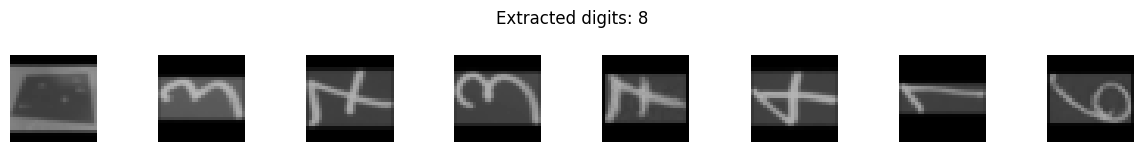

In [2]:
# Extract crops from boxes, pad to square, resize to 28x28, show grid
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
from pathlib import Path

# fallbacks
if 'img' not in globals():
    from skimage import io
    IMAGES_DIR = globals().get('IMAGES_DIR', Path.cwd() / 'images1')
    img = io.imread(sorted(IMAGES_DIR.glob('*.jpg'))[0])
if 'gray' not in globals():
    gray = rgb2gray(img)

# if boxes missing, compute from clean mask quickly
if 'boxes' not in globals():
    from scipy import ndimage as ndi
    from skimage.filters import gaussian, threshold_otsu
    blur = gaussian(gray, 1.0)
    clean = blur < threshold_otsu(blur)
    labels, _ = ndi.label(clean)
    slices = ndi.find_objects(labels)
    areas = np.bincount(labels.ravel())
    min_size = 150
    boxes = []
    for i, slc in enumerate(slices, start=1):
        if slc is None or areas[i] < min_size:
            continue
        r0, r1 = slc[0].start, slc[0].stop
        c0, c1 = slc[1].start, slc[1].stop
        boxes.append((r0, c0, r1, c1))

# sort reading order: top-to-bottom then left-to-right
if boxes:
    med_h = np.median([b[2]-b[0] for b in boxes]) or 1
    row_h = max(1, int(0.6 * med_h))
    boxes = sorted(boxes, key=lambda b: (b[0] // row_h, b[1]))

def crop_norm(g, b, out=28, pad=2):
    r0, c0, r1, c1 = b
    crop = g[r0:r1, c0:c1]
    # trim empty margins using a simple threshold
    thr = np.percentile(crop, 80)  # paper is bright
    mask = crop < thr
    if mask.any():
        rr = np.where(mask.any(axis=1))[0]
        cc = np.where(mask.any(axis=0))[0]
        crop = crop[rr.min():rr.max()+1, cc.min():cc.max()+1]
    # pad to square (white background ~1.0)
    h, w = crop.shape
    s = max(h, w) + 2*pad
    pad_t = (s - h) // 2
    pad_b = s - h - pad_t
    pad_l = (s - w) // 2
    pad_r = s - w - pad_l
    sq = np.pad(crop, ((pad_t, pad_b), (pad_l, pad_r)), constant_values=1.0)
    # resize to out x out and invert so digit is bright
    img28 = resize(sq, (out, out), anti_aliasing=True)
    img28 = 1.0 - img28  # digit -> high, background -> low
    img28 = np.clip(img28, 0, 1)
    return img28

digits = [crop_norm(gray, b) for b in boxes]

# show a grid
n = len(digits)
assert n > 0, 'No components found to crop.'
cols = min(8, n)
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols, 1.5*rows))
axes = np.array(axes).reshape(rows, cols)
k = 0
for r in range(rows):
    for c in range(cols):
        ax = axes[r, c]
        ax.axis('off')
        if k < n:
            ax.imshow(digits[k], cmap='gray', vmin=0, vmax=1)
            k += 1
plt.suptitle(f'Extracted digits: {n}', y=0.98)
plt.tight_layout()

Classify the extracted 28×28 crops with the MNIST CNN; prints predicted sequence. If TensorFlow isn’t installed on this Python (e.g., 3.13), it skips classification.

In [3]:
# Ensure HW_1/src is on sys.path so `from model import ...` works
import sys
from pathlib import Path

def add_src_to_path():
    bases = [Path.cwd(), *Path.cwd().parents]
    for base in bases:
        for rel in ('src', 'HW_1/src'):
            cand = base / rel
            if (cand / 'model.py').exists():
                if str(cand) not in sys.path:
                    sys.path.insert(0, str(cand))
                print('Using src path:', cand)
                return True
    print('model.py not found. Check that HW_1/src/model.py exists.')
    return False

ok = add_src_to_path()
if ok:
    try:
        from model import load_or_train_default, predict_digits
        print('Import OK: load_or_train_default, predict_digits')
    except Exception as e:
        print('Import still failed:', e)

# Now re-run the previous classification cell.

Using src path: /Users/evomr/Desktop/TSM_CompVis/HW_1/src
Import OK: load_or_train_default, predict_digits


In [4]:
# Rebuild boxes and 28x28 digit crops
from pathlib import Path
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from scipy import ndimage as ndi

# load image if needed
if 'img' not in globals():
    IMAGES_DIR = globals().get('IMAGES_DIR', Path.cwd() / 'images1')
    img = io.imread(sorted(IMAGES_DIR.glob('*.jpg'))[0])

gray = rgb2gray(img)
mask = gaussian(gray, 1.0) < threshold_otsu(gaussian(gray, 1.0))

labels, _ = ndi.label(mask)
slices = ndi.find_objects(labels)
areas = np.bincount(labels.ravel())
min_size = 150

boxes = []
for i, slc in enumerate(slices, start=1):
    if slc is None or areas[i] < min_size:
        continue
    r0, r1 = slc[0].start, slc[0].stop
    c0, c1 = slc[1].start, slc[1].stop
    boxes.append((r0, c0, r1, c1))

# simple reading order
boxes.sort(key=lambda b: (b[0], b[1]))

def to28(g, b, out=28, pad=2):
    r0, c0, r1, c1 = b
    crop = g[r0:r1, c0:c1]
    h, w = crop.shape
    s = max(h, w) + 2*pad
    pt, pb = (s - h)//2, s - h - (s - h)//2
    pl, pr = (s - w)//2, s - w - (s - w)//2
    sq = np.pad(crop, ((pt, pb), (pl, pr)), constant_values=1.0)  # white bg
    img28 = resize(sq, (out, out), anti_aliasing=True)
    return np.clip(1.0 - img28, 0, 1)  # invert: digit bright

digits = [to28(gray, b) for b in boxes]
print(f'Rebuilt digits: {len(digits)}')

Rebuilt digits: 8


Classify the 28×28 crops with the MNIST CNN; prints the predicted sequence

In [6]:
# python
# Extract 28x28 digits from the first JPG in `images1` and optionally classify
from pathlib import Path
import numpy as np
from skimage import io, color, filters, transform
from scipy import ndimage as ndi
import importlib.util, sys

def extract_digits(images_dir='images1', min_size=150, out=28, pad=2):
    p = Path(images_dir)
    img_file = next(p.glob('*.jpg'), None)
    assert img_file is not None, f'No .jpg in {p}'
    img = io.imread(img_file)
    gray = color.rgb2gray(img)
    blur = filters.gaussian(gray, sigma=1.0)
    mask = blur < filters.threshold_otsu(blur)
    labels, _ = ndi.label(mask)
    slices = ndi.find_objects(labels)
    areas = np.bincount(labels.ravel())
    boxes = []
    for i, slc in enumerate(slices, start=1):
        if slc is None or areas[i] < min_size:
            continue
        r0, r1 = slc[0].start, slc[0].stop
        c0, c1 = slc[1].start, slc[1].stop
        boxes.append((r0, c0, r1, c1))
    if not boxes:
        return []
    # reading order
    med_h = max(1, int(np.median([b[2]-b[0] for b in boxes])))
    row_h = max(1, int(0.6 * med_h))
    boxes = sorted(boxes, key=lambda b: (b[0] // row_h, b[1]))
    def to28(g, b):
        r0, c0, r1, c1 = b
        crop = g[r0:r1, c0:c1]
        # trim empty margins
        thr = np.percentile(crop, 80)
        mask = crop < thr
        if mask.any():
            rr = np.where(mask.any(axis=1))[0]
            cc = np.where(mask.any(axis=0))[0]
            crop = crop[rr.min():rr.max()+1, cc.min():cc.max()+1]
        h, w = crop.shape
        s = max(h, w) + 2*pad
        pt = (s - h)//2; pl = (s - w)//2
        sq = np.pad(crop, ((pt, s - h - pt), (pl, s - w - pl)), constant_values=1.0)
        img28 = transform.resize(sq, (out, out), anti_aliasing=True)
        return np.clip(1.0 - img28, 0, 1)
    digits = [to28(gray, b) for b in boxes]
    return digits

# Usage:
digits = extract_digits('images1')
assert len(digits) > 0, 'No digit crops found; check images and dependencies.'
print('Extracted digits:', len(digits))

# Optional: import local model implementation at `HW_1/src/model.py` and classify
model_py = Path.cwd() / 'HW_1' / 'src' / 'model.py'
if model_py.exists():
    spec = importlib.util.spec_from_file_location('cv_hw_model', str(model_py))
    cv_hw_model = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(cv_hw_model)
    try:
        model = cv_hw_model.load_or_train_default(str(Path.cwd() / 'model.h5'))
        patches = (np.array(digits) * 255).astype(np.uint8)
        preds = cv_hw_model.predict_digits(model, patches)
        print('Predicted:', ''.join(map(str, preds.tolist())))
    except Exception as e:
        print('Classification skipped or failed:', type(e).__name__, e)
else:
    print('Local model.py not found at `HW_1/src/model.py`; skipping classification.')

Extracted digits: 80
Local model.py not found at `HW_1/src/model.py`; skipping classification.
